### MNIST Digit Recognizer

In [1]:
from fastai.vision.all import *

In [2]:
# imgs location 
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
# Download train/validation data
path = untar_data(URLs.MNIST_SAMPLE)

threes_train = torch.stack([
    tensor(Image.open(number)) for number in (path/'train'/'3').ls().sorted()
])

sevens_train = torch.stack([
    tensor(Image.open(number)) for number in (path/'train'/'7').ls().sorted()
])


threes_val = torch.stack([
    tensor(Image.open(number)) for number in (path/'valid'/'3').ls().sorted()
])

sevens_val = torch.stack([
    tensor(Image.open(number)) for number in (path/'valid'/'7').ls().sorted()
])

print('3s Train Shape: ', threes_train.shape)
print('7s Train Shape: ', sevens_train.shape)

print('3s Validation Shape: ', threes_val.shape)
print('7s Validation Shape: ', sevens_val.shape)

3s Train Shape:  torch.Size([6131, 28, 28])
7s Train Shape:  torch.Size([6265, 28, 28])
3s Validation Shape:  torch.Size([1010, 28, 28])
7s Validation Shape:  torch.Size([1028, 28, 28])


- **Binary classification tasks, classes are balanced**

In [4]:
# Conver to float and scale the imgs (0 - 1)
threes_train = threes_train.float()/255
sevens_train = sevens_train.float()/255

threes_val = threes_val.float()/255
sevens_val = sevens_val.float()/255

In [5]:
# Concatenate all imgs into a single tensor and change them from a list of matrices to a list of vectors
train_x = torch.cat([threes_train, sevens_train]).view(-1, 28*28)
val_x = torch.cat([threes_val, sevens_val]).view(-1, 28*28)

print('Train Tensor Shape: ', train_x.shape)
print('Validation Tensor Shape: ', val_x.shape)

Train Tensor Shape:  torch.Size([12396, 784])
Validation Tensor Shape:  torch.Size([2038, 784])


- `view` is PyTorch method that changes the shape of a tensor without changing its contents
- `-1` means make this axis as big as necessary to fit all the data

In [6]:
# Because we have only two classes (3s and 7s) - make labels for them as 1 and 0
train_y = tensor([1]*threes_train.shape[0] + [0]*sevens_train.shape[0]).unsqueeze(1)
val_y = tensor([1]*threes_val.shape[0] + [0]*sevens_val.shape[0]).unsqueeze(1)

In [7]:
# Get the shape 
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)

torch.Size([12396, 784]) torch.Size([12396, 1])
torch.Size([2038, 784]) torch.Size([2038, 1])


In [8]:
# A Dataset in PyTorch is required to return a tuple of (x, y)
dset_train = list(zip(train_x, train_y))
dset_val = list(zip(val_x, val_y))

x, y = dset_train[0] # first observation and its label from train data
x.shape, y

(torch.Size([784]), tensor([1]))

In [9]:
# Create a function for weight initialization
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

weights = init_params(28*28, 1)
print('Weights Shape: ', weights.shape)

Weights Shape:  torch.Size([784])


**Important**

The function `weights*pixels` won’t be flexible enough. It is always equal to 0 when the pixels are equal to 0. You might remember from high school
math that the formula for a line is `y=w*x+b`. **We still need the b (bias).** We’ll initialize it to a random number too

In [10]:
bias = init_params(1)
bias

tensor([-0.4393], requires_grad=True)

In [11]:
# Prediction for a single img
pred = (train_x[0]*weights.T).sum() + bias
pred

tensor([4.9566], grad_fn=<AddBackward0>)

### How to Calculate Predictions for Each Image?
- `Loop Usage` - very slow 
- `Matrix Multiplication` - very fast 

`train_x` is a matrix, `w` is a column-vector (matrix),  `b` is a vector. **Using all these we can get prediction for each image incredibly fast**

In [12]:
def get_predictions(x, w, b):
    return x@w + b # fundamental equation of any DL net

preds = get_predictions(
    train_x,
    weights,
    bias
)

preds

tensor([ 4.9566, 12.0457, 12.6466,  ..., 20.3852,  7.5482, -3.0783],
       grad_fn=<AddBackward0>)

### How to Get the Labels?
We have a binary classification problem. So we can say that if the prediction is greater than 0 - it's 3, otherwise 7

In [13]:
is_correct_pred = (preds > 0.0).float() == train_y
print('Accuracy: ', is_correct_pred.float().mean().item())

Accuracy:  0.49598419666290283


**Above we got this accuracy using random weights**

Now let’s see what the change in accuracy is for a small change in one of the weights:

In [14]:
weights[0].data *= 1.0001

preds = get_predictions(
    train_x,
    weights,
    bias
)

((preds>0.0).float() == train_y).float().mean().item()

0.49598419666290283

**Conclusion**

To improve the model quality **we need to define the loss function and then get the gradients with respect to the weights.** 

### Loss Function Choosing

So, we need to choose a loss function. The obvious approach would be to use accuracy, which is our metric, as our loss function as well. In this case, we would calculate our prediction for each image, collect these values to calculate an overall accuracy, and then calculate the gradients of each weight with respect to that overall accuracy.

Unfortunately, we have a significant technical problem here. 
- **The gradient of a function is its slope, or its steepness**, 

It can be defined as rise over run—that is: *how much the value of the function goes up or down, divided by how much we changed
the input.*

We can write this mathematically as: 
- `(y_new – y_old) / (x_new – x_old)`

This gives a good approximation of the gradient when `x_new` is very similar to `x_old`, meaning that their difference is very small. **But accuracy changes at all only when a prediction changes from a 3 to a 7, or vice versa.**

- The problem is that a small change in weights from `x_old` to `x_new` isn’t likely to cause any prediction to change, so
`(y_new – y_old)` will almost always be 0. 

In other words, the gradient is 0 almost everywhere. **A very small change in the value of a weight will often not change the accuracy at all.**
This means **it is not useful to use accuracy as a loss function. If we do, most of the time our gradients will be 0**, and the model will not be able to learn from that number.

**Instead, we need a loss function that, when our weights result in slightly better predictions, gives us a slightly better loss.** So what does a “slightly better prediction” look like, exactly? Well, in this case, it means that if the correct answer is a 3, the score is a little higher, or if the correct answer is a 7, the score is a little lower.

**The loss function receives not the images themselves, but the predictions from the model.** So let’s make one argument, `preds`, of values between 0 and 1, where each value is the prediction that an image is a 3. It is a vector (i.e., a rank-1 tensor) indexed over the images.

- **The purpose of the loss function is to measure the difference between predicted values and the true values (targets/labels)**
- **Loss must be a function that has a meaningful derivative!**
- **The loss function is calculated for each item in our dataset, and then at the end of an epoch, the loss values are all averaged and the overall mean is reported for the epoch.**
- **It is important that we learn to focus on the metrics, rather than the loss, when judging the performance of a model.**

Let’s therefore make another argument, `targets`, with values of 0 or 1 that tells whether an image actually is a 3 or not. It is also a vector (i.e., another rank-1 tensor) indexed over the images.

**Example**

Suppose we had three images that we knew were 3, 7, 3. And suppose our model predicted with high confidence (0.9) - 3, with slight confidence (0.4) - 7, and with fair confidence (0.2) - 7. This would mean our loss function would receive these values as its inputs:

In [15]:
# 3 - class_1, 7 - class_0
targets = tensor([1, 0, 1]) # 3, 7, 3
preds = tensor([0.9, 0.4, 0.2]) # 3, 7, 7

In [16]:
# let's try a loss that measures the distance between predictions and targets:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1 - predictions, predictions).mean() # use mean because we need a scalar for the loss

mnist_loss(preds, targets)

tensor(0.4333)

We can see that out loss returns:
- low value if prediction is correct and confident
- Higher value if the predictions is correct and not so confident 
- High value if the prediction is incorrect and not so confident 
- Very high value if the prediction is incorrect and very confident

In [17]:
# let's change the last prediction to correct and confident
mnist_loss(
    tensor([0.9, 0.4, 0.8]), # 3, 7, 3
    targets # 3, 7, 3
)

tensor(0.2333)

The loss has decreased. One problem with `mnist_loss` as currently defined is that **it assumes that predictions are always between 0 and 1.** We need to ensure, then, that this is actually the case! As it happens, there is a function that does exactly that . let’s take a look:

**Sigmoid**

The sigmoid function always outputs a number between 0 and 1.

In [18]:
from fastbook import *

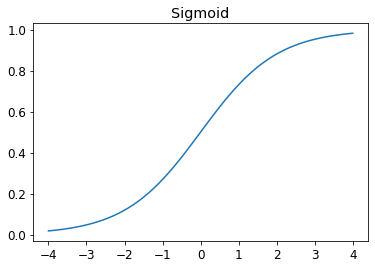

In [19]:
def sigmoid(x): 
    return 1 / (1 + torch.exp(-x))

plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

- this function is smooth and goes up (good for the gradients calculation)

In [20]:
# Let’s update mnist_loss to first apply sigmoid to the inputs
def mnist_loss(predictions, targets):
    predictions = sigmoid(predictions)
    return torch.where(targets==1, 1 - predictions, predictions).mean()

Now we can be confident our loss function will work, even if the predictions are not between 0 and 1. But usually we ge the probability that is always between 0 and 1 (classifier confidence), then compute the loss.

### Gradient Descent and Mini-Batches
To take an optimization step, we need to calculate the loss over one or more data items. How many should we use? 

Usually we average the loss over on n items. The number of data items in the mini-batch is called **batch size**

- Mini-Batch solution is good for GPU training
- Don't forget to shuffle each mini batch 

**Large Batch Size**
- Get a more accurate and stable estimate of your dataset’s gradients from the loss function
- Takes longer to train

**Good Batch Size**
- Good estimate of the gradients 
- Optimal training time 

PyTorch and fastai provide a class that will do the shuffling and mini-batch collation for you, called `DataLoader`

In [21]:
n_elements = range(15)
dl = DataLoader(n_elements, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

For training a model, we don’t just want any Python collection, but a collection containing independent and dependent variables (the inputs and targets of the model). 

A **collection that contains tuples of independent and dependent variables is known in PyTorch as a Dataset.**

Here’s an example of an extremely simple Dataset

In [26]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

When we pass a Dataset to a DataLoader we will get back many batches that are themselves tuples of tensors representing batches of independent and dependent variables

In [27]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([19, 14,  0, 24, 20, 12]), ('t', 'o', 'a', 'y', 'u', 'm')),
 (tensor([23,  8,  9,  3, 16,  6]), ('x', 'i', 'j', 'd', 'q', 'g')),
 (tensor([ 4,  7,  1, 13,  2, 22]), ('e', 'h', 'b', 'n', 'c', 'w')),
 (tensor([ 5, 17, 18, 10, 11, 15]), ('f', 'r', 's', 'k', 'l', 'p')),
 (tensor([25, 21]), ('z', 'v'))]

In [39]:
# Init params 
weigths = init_params((28*28, 1))
bias = init_params(1)

In [31]:
# First, create DataLoader from Dataset (train)
dl_train = DataLoader(dset_train, batch_size=256)

# look at first batch 
x_dl_train, y_dl_train = first(dl_train)
x_dl_train.shape, y_dl_train.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [41]:
# DataLoader for val data 
dl_val = DataLoader(dset_val, batch_size=256)

# look at first batch 
x_dl_val, y_dl_val = first(dl_val)
x_dl_val.shape, y_dl_val.shape

(torch.Size([256, 784]), torch.Size([256, 1]))